<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

### Boostrap vs. Spatial Bootstrap in Python 

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


#### Bootstrap

Uncertainty in the sample statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less wells provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?

**Bootstrap** is a method to assess the uncertainty in a sample statistic by repeated random sampling with replacement.

Assumptions
* sufficient, representative sampling, identical, idependent samples

Limitations
1. assumes the samples are representative 
2. assumes stationarity
3. only accounts for uncertainty due to too few samples, e.g. no uncertainty due to changes away from data
4. does not account for boundary of area of interest 
5. assumes the samples are independent
6. does not account for other local information sources

The Bootstrap Approach (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

1. assemble a sample set, must be representative, reasonable to assume independence between samples

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

3. For $\ell = 1, \ldots, L$ realizations, do the following:

    * For $i = \alpha, \ldots, n$ data, do the following:

        * Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

6. Calculate a realization of the sammary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. Return to 3 for another realization.

7. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  Let's try it out.

#### Load the Required Libraries

We will also need some standard Python packages. These should have been installed with Anaconda 3.

In [10]:
supress_warnings = True                                   # supress warnings?
import numpy as np                                        # ndarrys for gridded data
import pandas as pd
import matplotlib.pyplot as plt                           # for plotting
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import scipy as sp                                        # lower upper matrix decomposition
from scipy.interpolate import make_interp_spline          # smooth curves
import statsmodels.formula.api as smf
from scipy.stats import norm                              # Gaussian distribution PDF and sampling
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
from ipywidgets import interactive                        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
cmap = plt.cm.inferno                                     # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                            # grid behind plotting elements
if supress_warnings == True:
    import warnings                                       # supress any warnings for this demonstration
    warnings.filterwarnings('ignore')                  

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

I just added a convenience functions to:

1. add major and minor gridlines
2. calculate a isotropic variogram between 2 points
3. calculate the azimuth between 2 points to rotate a label

In [11]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks    


    
    
def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = geostats.setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = geostats.cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = sp.linalg.lu(cov) 
    
# Build realization and calculate the average    
    realizations = np.zeros((nreal,nd))
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realizations[l,:] = np.matmul(L,rand)
        average_array[l] = np.average(realizations[l])
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    return n_eff, realizations
    
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

#### n Effective Demonstration

Now let's set up our first dashboard. Here we visualize the impact of spatial continuity range and number of samples on the effective number of data. 

* How many independent peices of information do you have?

In [19]:
max_L = 100

l = widgets.Text(value=r'                                                      Number of Effective Data, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

n = widgets.IntSlider(min=1, max = max_L, value = 1,step = 1,description = '$n$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
n.style.handle_color = 'gray'

vrange = widgets.FloatSlider(min=0.1, max = 200.0, value = 10.0,step=5,description = r'$\gamma_{range}$',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
vrange.style.handle_color = 'gray'

seed = widgets.IntSlider(min=100, max = 999, value = 1, description = '$s$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
seed.style.handle_color = 'gray'

window = widgets.Checkbox(value=False,description='Conv. Fit',disabled=False,layout=Layout(width='200px', height='30px'))
poly = widgets.Checkbox(value=True,description='Poly. Fit',disabled=False,layout=Layout(width='200px', height='30px'))

ui1 = widgets.HBox([n,vrange,seed,],kwargs = {'justify_content':'center'})
ui2 = widgets.HBox([window,poly,],kwargs = {'justify_content':'center'})
ui_all = widgets.VBox([l,ui1,ui2],)

def f_make1(n,vrange,seed,window,poly): 
    np.random.seed(seed=seed)
    values = np.random.rand(max_L*2)*100
    X,Y = np.split(values,2)
    df = pd.DataFrame(np.vstack((X[:n],Y[:n])).T,columns = ['X','Y'])
    
    ax1 = plt.subplot(121)
    plt.scatter(df['X'],df['Y'],color='red',edgecolor='black',zorder=10,label = 'Spatial Data')
    plt.gca().add_patch(plt.Rectangle((0, 0), 100, 100, fill=False,edgecolor='black',lw=2))
    
    for ipts in range(0,n):
        if ipts == 0:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.1,zorder=1,label='Spatial Continuity')
        else:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.1,zorder=1)
        plt.gca().add_patch(circle1)
    
    plt.xlim([-10,110]); plt.ylim([-10,110]); add_grid(); plt.xlabel("X (m)"); plt.ylabel("Y (m)") 
    plt.title('Random Spatial Dataset with Spatial Correlation Range Indicated')
    
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=vrange,hmin1=vrange)
    neffective = n_effective(df,'X','Y',seed=seed,nreal=1000,vario=vario)[0]
    
    neffect_array = []; l_array = []
    for l in np.arange(1,max_L,2):
        l_array.append(l)
        df = pd.DataFrame(np.vstack((X[:l],Y[:l])).T,columns = ['X','Y'])
        neffect_array.append(n_effective(df,'X','Y',seed=seed,nreal=1000,vario=vario)[0])
    
    df_effective = pd.DataFrame(np.vstack((l_array,neffect_array)).T,columns = ['l','e'])    
    olsres2 = smf.ols(formula = 'e ~ l + I(l**2)+ I(l**3)-1', data = df_effective).fit()    
      
    plt.annotate(r'$n$ = ' + str(np.round(n,2)),(0,-5))
    plt.annotate(r'$n_{effective}$ = ' + str(np.round(neffective,2)),(15,-5))
    neffective_model = olsres2.params[2]*np.power(n,3) + olsres2.params[1]*np.power(n,2) + olsres2.params[0]*n
    plt.annotate(r'$\hat{n}_{effective}$ = ' + str(np.round(neffective_model,2)),(42,-5))
    plt.legend(loc = 'upper left')
        
    ax2 = plt.subplot(122)
    plt.plot([1,max_L],[1,max_L],color='black')
    plt.scatter(n,neffective,c='red',edgecolor='black',s=20,zorder=10)
    plt.scatter(n,neffective_model,c='darkorange',edgecolor='black',s=20,zorder=10)
    plt.scatter(l_array,neffect_array,c='grey',edgecolor='grey',lw=0,s=30,alpha=0.4,zorder=5)
    kernel = np.array([0.076923,0.230769,0.384615,0.230769,0.076923])
    #plt.plot(np.arange(1,max_L+1,1),poly(np.arange(1,max_L+1,1)),c='red',zorder=1) 
    if window:
        plt.plot(l_array[2:-2],np.convolve(neffect_array,kernel,mode = 'valid'),c='red',zorder=1) 
    # plt.plot(np.arange(1,max_L,3),max_pool,c='red',zorder=1) 
    if poly:
        xs = np.arange(1,max_L,1)
        neff_poly_model = olsres2.params[2]*np.power(xs,3) + olsres2.params[1]*np.power(xs,2) + olsres2.params[0]*xs
        plt.plot(xs,neff_poly_model,color='darkorange',zorder=10)
        plt.fill_between(xs,neff_poly_model,np.zeros(len(xs)),color='darkorange',alpha=0.2,zorder=1,label='Effective')
        plt.fill_between(xs,xs,neff_poly_model,color='grey',alpha=0.2,zorder=1,label='Ineffective')
        plt.legend(loc='upper left')
        
    plt.plot([0,n],[n,n],c='grey',zorder=3)
    plt.plot([n,n],[0,n],c='grey',zorder=3)

    if n > 10: 
        plt.annotate('No Spatial Correlation = ' + str(np.round(n,2)),[1.2,n+0.4],c='grey',zorder=3)
        if abs(n - neffective) > 1.5:
            plt.annotate('With Spatial Correlation = ' + str(np.round(neffective_model,2)),[1.2,neffective_model+0.4],c='darkorange',zorder=5)
            plt.plot([n,n],[0,neffective_model],c='darkorange',zorder=5); 
            plt.plot([0,n],[neffective_model,neffective_model],c='darkorange',zorder=5) 
    
    plt.ylim([1,max_L]); plt.xlim([1,max_L]); plt.xscale("linear"); plt.yscale("linear")
    plt.xlabel("Number of Samples"); plt.ylabel("Number of Independent Samples"); plt.title(r'Number of Independent Samples ($n_{effective}$) vs. Number of Samples')
    add_grid()
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); 
    plt.savefig('SpatialBootstrap.jpg',dpi=600,bbox_inches='tight')  
    plt.show()
    
interactive_plot1 = widgets.interactive_output(f_make1, {'n':n,'vrange':vrange,'seed':seed,'window':window,'poly':poly})
interactive_plot1.clear_output(wait = True)                # reduce flickering by delaying plot updating  

In [20]:
display(ui_all, interactive_plot1)                            # display the interactive plot

Output()

In [5]:
UNDER CONSTRUCTION

SyntaxError: invalid syntax (586471281.py, line 1)

In [49]:
nreal = 100

l = widgets.Text(value=r'                                                      Number of Effective Data, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

n = widgets.IntSlider(min=1, max = max_L, value = 1,step = 1,description = r'$n$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
n.style.handle_color = 'gray'

vrange = widgets.FloatSlider(min=0.1, max = 200.0, value = 10.0,step=5,description = r'$\gamma_{range}$',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
vrange.style.handle_color = 'gray'

ireal = widgets.IntSlider(min=1, max = nreal, value = 1,step = 1,description = r'$\ell$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
ireal.style.handle_color = 'gray'

seed = widgets.IntSlider(min=100, max = 999, value = 1, description = r'$s$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
seed.style.handle_color = 'gray'

window = widgets.Checkbox(value=False,description='Conv. Fit',disabled=False,layout=Layout(width='200px', height='30px'))
poly = widgets.Checkbox(value=True,description='Poly. Fit',disabled=False,layout=Layout(width='200px', height='30px'))

ui1 = widgets.HBox([n,vrange,ireal,seed,],kwargs = {'justify_content':'center'})
ui2 = widgets.HBox([window,poly,],kwargs = {'justify_content':'center'})
ui_all2 = widgets.VBox([l,ui1,ui2],)

def f_make2(n,vrange,ireal,seed,window,poly):
    
    nreal = 100;
    maxf = 50; maxfboot = 15
    dx = -5; dy = 3; pdfy = 13.0
    
    np.random.seed(seed=seed)
    values = np.random.rand(max_L*2)*100
    X,Y = np.split(values,2)
    df = pd.DataFrame(np.vstack((X[:n],Y[:n])).T,columns = ['X','Y'])
    
    ax1 = plt.subplot(121)
    plt.scatter(df['X'],df['Y'],marker='x',s=30,color='red',edgecolor='black',lw=2,zorder=10,label = 'Spatial Data')
    plt.scatter(df['X'],df['Y'],marker='x',s=40,color='white',edgecolor='black',lw=4,zorder=9,label = 'Spatial Data')
    plt.gca().add_patch(plt.Rectangle((0, 0), 100, 100, fill=False,edgecolor='black',lw=2))
    
    xx = np.arange(-3,3,0.1)
    pdf = norm.pdf(xx, loc=0, scale=1) * pdfy
    px = np.linspace(0,10,len(xx))
    
    for ipts in range(0,n):
        if ipts == 0:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.05,zorder=1,label='Spatial Continuity')
        else:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.05,zorder=1)
        plt.gca().add_patch(circle1)
        
        plt.plot([df['X'][ipts]+dx,df['X'][ipts]+10+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+dy],color='black')
        plt.plot([df['X'][ipts]+dx,df['X'][ipts]+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+5+dy],color='black')
        plt.plot(px + df['X'][ipts] + dx,pdf + df['Y'][ipts] + dy,color = 'black',zorder=1)
    
    plt.xlim([-10,110]); plt.ylim([-10,110]); add_grid(); plt.xlabel("X (m)"); plt.ylabel("Y (m)") 
    plt.title('Random Spatial Dataset with Spatial Correlation Range Indicated')
    
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=vrange,hmin1=vrange)
    neffective,realizations = n_effective(df,'X','Y',seed=seed,nreal=nreal,vario=vario)
    
    for ipts in range(0,n):
        y = df['Y'][ipts]+dy; x = df['X'][ipts]+dx+(realizations[ireal-1,ipts]-(-3.0))/(3.0-(-3.0))*10
        plt.plot([x,x],[y,y+5],color='black',lw=3,zorder=1); plt.plot([x,x],[y,y+5],color='red',lw=1,zorder=3)
    
    ax2 = plt.subplot(122)
    plt.axis('off'); plt.xlim([0, 10]); plt.ylim([0, 10])
    
    plt.plot([2,8],[6,6],color='black'); plt.plot([2,2],[6,9],color='black')
    
    xpmin = 2; xpmax = 8; ypmin = 6; ypmax = 9
    xprange = xpmax - xpmin; yprange = ypmax - ypmin
    xmin = -3.0; xmax = 3.0; nbin = 16
    xhalf = (xmax-xmin)/(nbin-1)/2.0; xsize = xhalf*2.0
    xrange = xmax - xmin
    xbins = np.linspace(xmin,xmax,nbin)
    ybins = np.linspace(0.0,maxfboot,11)
    xcents = np.linspace(xmin + xhalf,xmax-xhalf,nbin-1)
    
    for ibin, xbin in enumerate(xbins):
        xx = ((xbin-xmin)/xrange*xprange)+xpmin
        plt.plot([xx,xx],[ypmin,ypmax],color='grey',lw=0.2,zorder=1)
        if ibin % 2 == 0:
            plt.plot([xx,xx],[ypmin-yprange*0.1,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.18),ha='center')
        else: 
            plt.plot([xx,xx],[ypmin-yprange*0.05,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.13),ha='center')
    
#     for xbin in xbins:
#         xx = ((xbin-xmin)/xrange*xprange)+xpmin
#         plt.plot([xx,xx],[ypmin-yprange*0.05,ypmin],color='black',zorder=3)
#         plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.15),ha='center')
#         plt.plot([xx,xx],[ypmin,ypmax],color='grey',lw=0.2,zorder=1)    
    
    for ybin in ybins:
        yy = (ybin)*3/maxfboot+6
        plt.plot([xpmin-xprange*0.04,xpmin],[yy,yy],color='black',zorder=3)
        plt.plot([xpmin,xpmax],[yy,yy],color='grey',lw=0.2,zorder=1)
        plt.annotate(np.round(ybin,1),(xpmin-xprange*0.05,yy),ha='right')
    
    histboot = np.histogram(realizations[ireal-1,:], bins=xbins, weights=None)[0]
    average = np.average(realizations[ireal-1,:])
    
    for ibin, prop in enumerate(histboot):
        xx = ((xcents[ibin]-xmin)/xrange*xprange)+xpmin
        yy = histboot[ibin]*yprange/maxfboot
        ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'darkorange',color='black', ))
        xavg = ((average-xmin)/xrange*xprange)+xpmin
        #plt.plot([xavg,xavg],[6,9],color='red')
        
    for ipts in range(0,n):
        xx = ((realizations[ireal-1,ipts]-xmin)/xrange*xprange)+xpmin 
        plt.scatter(xx,ypmin,color='red',edgecolor='black',s=20,alpha=1.0,zorder=100)
        
    plt.annotate('Spatial Bootstrap Distribution Realization',(xpmin+xprange*0.5,ypmax+yprange*0.08),ha='center') 
    plt.annotate('Feature (NSCORE)',(xpmin+xprange*0.5,ypmin-yprange*0.25),ha='center') 
    plt.annotate('Proportion',(xpmin-xprange*0.18,ypmin+yprange*0.5),va='center',rotation = 90.0) 
    
    plt.plot([2,8],[1,1],color='black'); plt.plot([2,2],[1,4],color='black')
    
    xpmin = 2; xpmax = 8; ypmin = 1; ypmax = 4
    xprange = xpmax - xpmin; yprange = ypmax - ypmin
    xmin = -3.0; xmax = 3.0; nbin = 16
    xhalf = (xmax-xmin)/(nbin-1)/2.0; xsize = xhalf*2.0
    xrange = xmax - xmin
    xbins = np.linspace(xmin,xmax,nbin)
    ybins = np.linspace(0.0,maxf,11)
    xcents = np.linspace(xmin + xhalf,xmax-xhalf,nbin-1)
    
    for ibin, xbin in enumerate(xbins):
        xx = ((xbin-xmin)/xrange*xprange)+xpmin
        plt.plot([xx,xx],[ypmin,ypmax],color='grey',lw=0.2,zorder=1)
        if ibin % 2 == 0:
            plt.plot([xx,xx],[ypmin-yprange*0.1,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.18),ha='center')
        else: 
            plt.plot([xx,xx],[ypmin-yprange*0.05,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.13),ha='center')
                 
    for ybin in ybins:
        yy = (ybin)*yprange/maxf+1
        plt.plot([xpmin-xprange*0.04,xpmin],[yy,yy],color='black',zorder=3)
        plt.plot([xpmin,xpmax],[yy,yy],color='grey',lw=0.2,zorder=1)
        plt.annotate(np.round(ybin,1),(xpmin-xprange*0.05,yy),ha='right')
    
    average = np.average(realizations[ireal-1,:])
    
    averages = np.average(realizations,axis=1)
    #hist_avg = np.histogram(averages[:ireal+1], bins=xbins, weights=None)[0]
    hist_avg = np.histogram(averages[:ireal], bins=xbins, weights=None)[0]
    
    for ibin, prop in enumerate(hist_avg):
        xx = ((xcents[ibin]-(-3.0))/(3-(-3))*6)+2
        yy = hist_avg[ibin]*3/maxf
        ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'gold',color='black',zorder=10))
        xavg = ((average-(-3.0))/(3.0-(-3.0))*6)+2
        plt.plot([xavg,xavg],[6,9],color='red')
    
    #hist_avg_prior = np.histogram(averages[:ireal], bins=xbins, weights=None)[0]
    if ireal > 1:
        hist_avg_prior = np.histogram(averages[:ireal-1], bins=xbins, weights=None)[0]
    
        for ibin, prop in enumerate(hist_avg):
            xx = ((xcents[ibin]-(-3.0))/(3-(-3))*6)+2
            yy = hist_avg_prior[ibin]*3/maxf
            ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'red',color='black',zorder=15))
            xavg = ((average-(-3.0))/(3.0-(-3.0))*6)+2
            #plt.plot([xavg,xavg],[6,9],color='red')
        
    plt.annotate('Spatial Bootstrap Average Realization',(xpmin+xprange*0.5,ypmax+yprange*0.08),ha='center') 
    plt.annotate('Bootstrap Average (NSCORE)',(xpmin+xprange*0.5,ypmin-yprange*0.30),ha='center') 
    plt.annotate('Frequency',(0.8,2.5),va='center',rotation = 90.0) 
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.savefig('SpatialBootstrap.jpg',dpi=600,bbox_inches='tight')  
    plt.show()
    
interactive_plot2 = widgets.interactive_output(f_make2, {'n':n,'vrange':vrange,'ireal':ireal,'seed':seed,'window':window,'poly':poly})
interactive_plot2.clear_output(wait = True)                # reduce flickering by delaying plot updating     

In [50]:
display(ui_all2, interactive_plot2)                            # display the interactive plot

Output()

In [36]:
nreal = 100

l = widgets.Text(value=r'                                                      Number of Effective Data, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

n = widgets.IntSlider(min=1, max = max_L, value = 1,step = 1,description = r'$n$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
n.style.handle_color = 'gray'

vrange = widgets.FloatSlider(min=0.1, max = 200.0, value = 10.0,step=5,description = r'$\gamma_{range}$',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
vrange.style.handle_color = 'gray'

ireal = widgets.IntSlider(min=1, max = nreal, value = 1,step = 1,description = r'$\ell$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
ireal.style.handle_color = 'gray'

seed = widgets.IntSlider(min=100, max = 999, value = 1, description = r'$s$:',orientation='horizontal',layout=Layout(width='300px', height='50px'),continuous_update=False)
seed.style.handle_color = 'gray'

window = widgets.Checkbox(value=False,description='Conv. Fit',disabled=False,layout=Layout(width='200px', height='30px'))
poly = widgets.Checkbox(value=True,description='Poly. Fit',disabled=False,layout=Layout(width='200px', height='30px'))

ui1 = widgets.HBox([n,vrange,ireal,seed,],kwargs = {'justify_content':'center'})
ui2 = widgets.HBox([window,poly,],kwargs = {'justify_content':'center'})
ui_all2 = widgets.VBox([l,ui1,ui2],)

def f_make2(n,vrange,ireal,seed,window,poly):
    
    nreal = 100;
    maxf = 50; maxfboot = 15
    dx = -5; dy = 3; pdfy = 13.0
    
    np.random.seed(seed=seed)
    values = np.random.rand(max_L*2)*100
    X,Y = np.split(values,2)
    df = pd.DataFrame(np.vstack((X[:n],Y[:n])).T,columns = ['X','Y'])
    
    ax1 = plt.subplot(121)
    plt.scatter(df['X'],df['Y'],marker='x',s=30,color='red',edgecolor='black',lw=2,zorder=10,label = 'Spatial Data')
    plt.scatter(df['X'],df['Y'],marker='x',s=40,color='white',edgecolor='black',lw=4,zorder=9,label = 'Spatial Data')
    plt.gca().add_patch(plt.Rectangle((0, 0), 100, 100, fill=False,edgecolor='black',lw=2))
    
    xx = np.arange(-3,3,0.1)
    pdf = norm.pdf(xx, loc=0, scale=1) * pdfy
    px = np.linspace(0,10,len(xx))
    
    for ipts in range(0,n):
        if ipts == 0:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.05,zorder=1,label='Spatial Continuity')
        else:
            circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
                lw=0.0,alpha=0.05,zorder=1)
        plt.gca().add_patch(circle1)
        
        plt.plot([df['X'][ipts]+dx,df['X'][ipts]+10+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+dy],color='black')
        plt.plot([df['X'][ipts]+dx,df['X'][ipts]+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+5+dy],color='black')
        plt.plot(px + df['X'][ipts] + dx,pdf + df['Y'][ipts] + dy,color = 'black',zorder=1)
    
    plt.xlim([-10,110]); plt.ylim([-10,110]); add_grid(); plt.xlabel("X (m)"); plt.ylabel("Y (m)") 
    plt.title('Random Spatial Dataset with Spatial Correlation Range Indicated')
    
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=vrange,hmin1=vrange)
    neffective,realizations = n_effective(df,'X','Y',seed=seed,nreal=nreal,vario=vario)
    
    for ipts in range(0,n):
        y = df['Y'][ipts]+dy; x = df['X'][ipts]+dx+(realizations[ireal,ipts]-(-3.0))/(3.0-(-3.0))*10
        plt.plot([x,x],[y,y+5],color='black',lw=3,zorder=1); plt.plot([x,x],[y,y+5],color='red',lw=1,zorder=3)
    
    ax2 = plt.subplot(122)
    plt.axis('off'); plt.xlim([0, 10]); plt.ylim([0, 10])
    
    plt.plot([2,8],[6,6],color='black'); plt.plot([2,2],[6,9],color='black')
    
    xpmin = 2; xpmax = 8; ypmin = 6; ypmax = 9
    xprange = xpmax - xpmin; yprange = ypmax - ypmin
    xmin = -3.0; xmax = 3.0; nbin = 6
    xhalf = (xmax-xmin)/(nbin-1)/2.0; xsize = xhalf*2.0
    xrange = xmax - xmin
    xbins = np.linspace(xmin,xmax,nbin)
    ybins = np.linspace(0.0,maxfboot,11)
    xcents = np.linspace(xmin + xhalf,xmax-xhalf,nbin-1)
    
    for xbin in xbins:
        xx = ((xbin-xmin)/xrange*xprange)+xpmin
        plt.plot([xx,xx],[ypmin-yprange*0.05,ypmin],color='black',zorder=3)
        plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.15),ha='center')
        plt.plot([xx,xx],[ypmin,ypmax],color='grey',lw=0.2,zorder=1)    
    
    for ybin in ybins:
        yy = (ybin)*3/maxfboot+6
        plt.plot([xpmin-xprange*0.04,xpmin],[yy,yy],color='black',zorder=3)
        plt.plot([xpmin,xpmax],[yy,yy],color='grey',lw=0.2,zorder=1)
        plt.annotate(np.round(ybin,1),(xpmin-xprange*0.05,yy),ha='right')
    
    histboot = np.histogram(realizations[ireal,:], bins=xbins, weights=None)[0]
    average = np.average(realizations[ireal,:])
    
    for ibin, prop in enumerate(histboot):
        xx = ((xcents[ibin]-xmin)/xrange*xprange)+xpmin
        yy = histboot[ibin]*yprange/maxfboot
        ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'darkorange',color='black', ))
        xavg = ((average-xmin)/xrange*xprange)+xpmin
        #plt.plot([xavg,xavg],[6,9],color='red')
        
    for ipts in range(0,n):
        xx = ((realizations[ireal,ipts]-xmin)/xrange*xprange)+xpmin 
        plt.scatter(xx,ypmin,color='red',edgecolor='black',s=20,alpha=1.0,zorder=100)
        
    plt.annotate('Spatial Bootstrap Distribution Realization',(xpmin+xprange*0.5,ypmax+yprange*0.08),ha='center') 
    plt.annotate('Feature (NSCORE)',(xpmin+xprange*0.5,ypmin-yprange*0.25),ha='center') 
    plt.annotate('Proportion',(xpmin-xprange*0.18,ypmin+yprange*0.5),va='center',rotation = 90.0) 
    
    plt.plot([2,8],[1,1],color='black'); plt.plot([2,2],[1,4],color='black')
    
    xpmin = 2; xpmax = 8; ypmin = 1; ypmax = 4
    xprange = xpmax - xpmin; yprange = ypmax - ypmin
    xmin = -3.0; xmax = 3.0; nbin = 16
    xhalf = (xmax-xmin)/(nbin-1)/2.0; xsize = xhalf*2.0
    xrange = xmax - xmin
    xbins = np.linspace(xmin,xmax,nbin)
    ybins = np.linspace(0.0,maxf,11)
    xcents = np.linspace(xmin + xhalf,xmax-xhalf,nbin-1)
    
    for ibin, xbin in enumerate(xbins):
        xx = ((xbin-xmin)/xrange*xprange)+xpmin
        plt.plot([xx,xx],[ypmin,ypmax],color='grey',lw=0.2,zorder=1)
        if ibin % 2 == 0:
            plt.plot([xx,xx],[ypmin-yprange*0.1,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.18),ha='center')
        else: 
            plt.plot([xx,xx],[ypmin-yprange*0.05,ypmin],color='black',zorder=3)
            plt.annotate(np.round(xbin,1),(xx,ypmin-yprange*0.13),ha='center')
                 
    for ybin in ybins:
        yy = (ybin)*yprange/maxf+1
        plt.plot([xpmin-xprange*0.04,xpmin],[yy,yy],color='black',zorder=3)
        plt.plot([xpmin,xpmax],[yy,yy],color='grey',lw=0.2,zorder=1)
        plt.annotate(np.round(ybin,1),(xpmin-xprange*0.05,yy),ha='right')
    
    average = np.average(realizations[ireal,:])
    
    averages = np.average(realizations,axis=1)
    #hist_avg = np.histogram(averages[:ireal+1], bins=xbins, weights=None)[0]
    
    for ibin, prop in enumerate(hist_avg):
        xx = ((xcents[ibin]-(-3.0))/(3-(-3))*6)+2
        yy = hist_avg[ibin]*3/maxf
        ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'gold',color='black',zorder=10))
        xavg = ((average-(-3.0))/(3.0-(-3.0))*6)+2
        plt.plot([xavg,xavg],[6,9],color='red')
    
    hist_avg_prior = np.histogram(averages[:ireal], bins=xbins, weights=None)[0]
    
    for ibin, prop in enumerate(hist_avg):
        xx = ((xcents[ibin]-(-3.0))/(3-(-3))*6)+2
        yy = hist_avg_prior[ibin]*3/maxf
        ax2.add_patch(plt.Rectangle((xx-xhalf,ypmin), xsize, yy, lw=1, fc = 'red',color='black',zorder=15))
        xavg = ((average-(-3.0))/(3.0-(-3.0))*6)+2
        #plt.plot([xavg,xavg],[6,9],color='red')
        
    plt.annotate('Spatial Bootstrap Average Realization',(xpmin+xprange*0.5,ypmax+yprange*0.08),ha='center') 
    plt.annotate('Bootstrap Average (NSCORE)',(xpmin+xprange*0.5,ypmin-yprange*0.30),ha='center') 
    plt.annotate('Frequency',(0.8,2.5),va='center',rotation = 90.0) 
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.savefig('SpatialBootstrap.jpg',dpi=600,bbox_inches='tight')  
    plt.show()
    
interactive_plot2 = widgets.interactive_output(f_make2, {'n':n,'vrange':vrange,'ireal':ireal,'seed':seed,'window':window,'poly':poly})
interactive_plot2.clear_output(wait = True)                # reduce flickering by delaying plot updating     

array([ 0.57744207, -0.12475772,  0.97571096,  1.59494036, -1.20194452,
       -1.28620972,  0.82640545,  0.78747084,  0.65703186,  1.50348689])

In [255]:
xmin = -3.0; xmax = 3.0; nbin = 16
xhalf = (xmax-xmin)/(nbin-1)/2.0
xbins = np.linspace(xmin,xmax,nbin)
ybins = np.linspace(0.0,maxf,11)
xcents = np.linspace(xmin + xhalf,xmax-xhalf,nbin-1)

xcents

array([-2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,
        1.6,  2. ,  2.4,  2.8])

In [206]:
hist_avg

array([0, 0, 3, 1, 0, 0], dtype=int64)

In [207]:
xbins

array([-3., -2., -1.,  0.,  1.,  2.,  3.])

In [210]:
averages[:ireal]

np.histogram(averages[:ireal], bins=xbins, weights=None)

(array([0, 0, 3, 1, 0, 0], dtype=int64),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]))

In [212]:
np.histogram(averages[:ireal-1], bins=xbins, weights=None)

(array([0, 0, 2, 1, 0, 0], dtype=int64),
 array([-3., -2., -1.,  0.,  1.,  2.,  3.]))

In [211]:
averages[:ireal]

array([-0.10180635,  0.3473193 , -0.08361122, -0.4094051 ])

In [213]:
averages[:ireal-1]

array([-0.10180635,  0.3473193 , -0.08361122])

In [214]:
np.average(realizations[ireal,:])

0.24737254766389993

In [217]:
averages[ireal]

0.24737254766389993

In [215]:
ireal

4

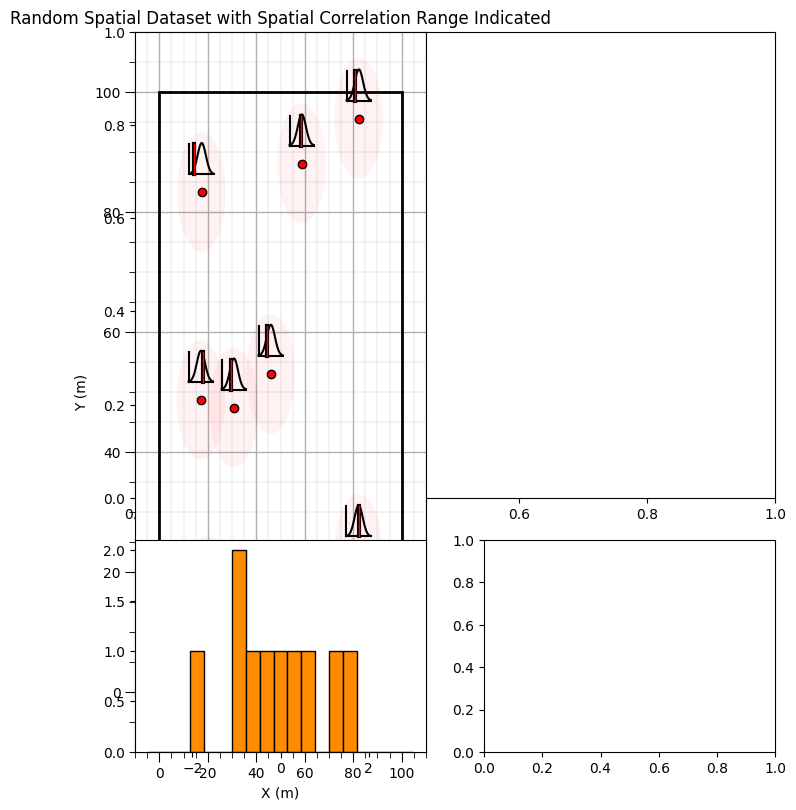

In [77]:
plt.subplot2grid((3,2), (0,0), colspan=2, rowspan = 2)

seed = 103; n = 10; max_L = 100; ireal = 2; nreal = 100
dx = -5; dy = 3; pdfy = 13.0

np.random.seed(seed=seed)
values = np.random.rand(max_L*2)*100
X,Y = np.split(values,2)
df = pd.DataFrame(np.vstack((X[:n],Y[:n])).T,columns = ['X','Y'])

ax1 = plt.subplot(121)
plt.scatter(df['X'],df['Y'],color='red',edgecolor='black',zorder=10,label = 'Spatial Data')
plt.gca().add_patch(plt.Rectangle((0, 0), 100, 100, fill=False,edgecolor='black',lw=2))

xx = np.arange(-3,3,0.1)
pdf = norm.pdf(xx, loc=0, scale=1) * pdfy
px = np.linspace(0,10,len(xx))

for ipts in range(0,n):
    if ipts == 0:
        circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
            lw=0.0,alpha=0.05,zorder=1,label='Spatial Continuity')
    else:
        circle1 = plt.Circle((df['X'][ipts],df['Y'][ipts]),vrange,fill=True,color='red',edgecolor=None,
            lw=0.0,alpha=0.05,zorder=1)
    plt.gca().add_patch(circle1)
    
    plt.plot([df['X'][ipts]+dx,df['X'][ipts]+10+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+dy],color='black')
    plt.plot([df['X'][ipts]+dx,df['X'][ipts]+dx],[df['Y'][ipts]+dy,df['Y'][ipts]+5+dy],color='black')
    plt.plot(px + df['X'][ipts] + dx,pdf + df['Y'][ipts] + dy,color = 'black',zorder=1)

plt.xlim([-10,110]); plt.ylim([-10,110]); add_grid(); plt.xlabel("X (m)"); plt.ylabel("Y (m)") 
plt.title('Random Spatial Dataset with Spatial Correlation Range Indicated')

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=vrange,hmin1=vrange)
neffective,realizations = n_effective(df,'X','Y',seed=seed,nreal=nreal,vario=vario)

for ipts in range(0,n):
    y = df['Y'][ipts]+dy; x = df['X'][ipts]+dx+(realizations[ireal,ipts]-(-3.0))/(3.0-(-3.0))*10
    plt.plot([x,x],[y,y+5],color='black',lw=3,zorder=1); plt.plot([x,x],[y,y+5],color='red',lw=1,zorder=3)

plt.subplot2grid((3,2), (2,0))

plt.hist(realizations[ireal,:],color='darkorange',edgecolor='black',bins=np.linspace(-3,3,20))

plt.subplot2grid((3,2), (2,1))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.5, wspace=0.2, hspace=0.2); plt.show()

In [29]:
display(ui1, interactive_plot1)                            # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 2 Axes>', 'i…

In [23]:
a = [12,12]+ 2
a

TypeError: can only concatenate list (not "int") to list

In [ ]:
olsres2 = smf.ols(formula = 'Y ~ X + I(X**2)-1', data = df).fit()
print(olsres2.summary())
xs = np.arange(1,max_L,1)
plt.plot(xs,olsres2.params[1]*np.power(xs,2) + olsres2.params[0]*xs)

In [ ]:
olsres2.params[1]

In [ ]:
l = widgets.Text(value='                                 Monte Carlo Method to Estimate Mean Demonstration, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

L = widgets.IntSlider(min=1, max = 40, value = 1, description = '$L$:',orientation='horizontal',layout=Layout(width='230px', height='50px'),continuous_update=False)
L.style.handle_color = 'gray'

dist1 = widgets.Dropdown(
    options=['Uniform','Triangular','Gaussian'],
    value='Gaussian',
    description='$X_1$:',
    disabled=False,
    layout=Layout(width='200px', height='30px')
)
min1 = widgets.FloatSlider(min=0.0, max = 100.0, value = 10.0, description = 'Min',orientation='horizontal',layout=Layout(width='230px', height='50px'),continuous_update=False)
min1.style.handle_color = 'gray'
max1 = widgets.FloatSlider(min=0.0, max = 100.0, value = 90.0, description = 'Max',orientation='horizontal',layout=Layout(width='230px', height='50px'),continuous_update=False)
max1.style.handle_color = 'gray'

ui = widgets.HBox([L,dist1,min1,max1],kwargs = {'justify_content':'center'})
ui1 = widgets.VBox([l,ui],)

def make_sample_cdist(dist,zmin,zmax,L):
    cdf = np.linspace(0.001,0.999,1000)
    pvals = np.random.random(size = L)
    if dist == 'Triangular':  
        distribution = stats.triang(loc = zmin,c=0.5,scale = zmax-zmin)
    if dist == 'Uniform':        
        distribution = stats.uniform(loc = zmin,scale = zmax-zmin)
    if dist == 'Gaussian':
        mean = (zmax + zmin)*0.5; stdev = (zmax - zmin)/6.0
        distribution = stats.norm(loc = mean,scale = stdev)
    
    cdfx = distribution.ppf(cdf)
    sample = distribution.ppf(pvals)
    
    return sample, pvals, cdfx, cdf 
        
def f_make1(L,dist1,min1,max1): 
    np.random.seed(seed = 73073)
    sample, pvals, cdfx, cdf = make_sample_cdist(dist1,min1,max1,L)
    truth_mean = np.average([min1,max1])
    counts = np.arange(1,len(sample)+1,1)

    L_all = 40
    np.random.seed(seed = 73073)
    sample_all, pvals_all, cdfx_all, cdf_all = make_sample_cdist(dist1,min1,max1,L_all)
    prop_all = np.cumsum(sample_all, axis=0, dtype=None, out=None)/np.arange(1,len(sample_all)+1,1)
    counts_all = np.arange(1,len(sample_all)+1,1)
    
    ax1 = plt.subplot(121)
    plt.plot(cdfx,cdf,'--',color='black',linewidth = 3,zorder=10); add_grid(ax1)
    plt.xlim(0,100); plt.ylim(0,1.0); plt.xlabel("$X_1$"); plt.title("Cumulative Distribution Function, $X_1$"); plt.ylabel('Cumulative Probability')
     
    for l in range(0,L):
        alpha = max(0.02,(6 - (L-l) )/5)
        dhead = 1;lhead = 0.02        
        if l == L-1:
            plt.plot([0.0,sample[l]],[pvals[l],pvals[l]],color='red',alpha = alpha,lw=1,zorder=1)
            plt.plot([sample[l],sample[l]],[pvals[l],lhead+0.02],color='red',alpha = alpha,lw=1,zorder=1)
            head = plt.Polygon([[sample[l],0.02],[sample[l]-dhead,lhead+0.02],[sample[l]+dhead,lhead+0.02],[sample[l],0.02]], color='red',alpha = alpha,zorder=1)
            plt.annotate(int(sample[l]),[sample[l]+1,0.07],rotation=90.0,color='red',alpha = alpha)
            plt.scatter(sample[l],0.01,s=30,color='red',edgecolor='black',alpha=1.0)
            plt.gca().add_patch(head)
        else:
            plt.plot([0.0,sample[l]],[pvals[l],pvals[l]],color='darkorange',alpha = alpha,lw=1,zorder=1)
            plt.plot([sample[l],sample[l]],[pvals[l],lhead+0.02],color='darkorange',alpha = alpha,lw=1,zorder=1)
            head = plt.Polygon([[sample[l],0.02],[sample[l]-dhead,lhead+0.02],[sample[l]+dhead,lhead+0.02],[sample[l],0.02]], color='darkorange',alpha = alpha,zorder=1)
            plt.annotate(int(sample[l]),[sample[l]+1,0.07],rotation=90.0,color='darkorange',alpha = alpha)
            plt.scatter(sample[l],0.01,s=10,color='yellow',edgecolor='black',alpha=1.0)
            plt.gca().add_patch(head)            

    ax2 = plt.subplot(122)
    plt.hist(sample,density= False,bins=np.linspace(0,100,20),weights=None,color='red',alpha=1.0,edgecolor='black',zorder=1)
    if l > 0:
        plt.hist(sample[:-1],density= False,bins=np.linspace(0,100,20),weights=None,color='darkorange',alpha=0.8,edgecolor='black',zorder=5)
    
    for l in range(0,L):
        if l == L-1:
            plt.scatter(sample[l],0.1,s=30,color='red',edgecolor='black',alpha=1.0,zorder=l+10)
        else:
            plt.scatter(sample[l],0.1,s=10,color='yellow',edgecolor='black',alpha=1.0,zorder=l+10)
    
    plt.vlines(truth_mean,0,10,colors='black',zorder=1000)
    plt.annotate('Population Mean',[truth_mean+1,7],rotation=270.0)
    
    plt.plot(prop_all,counts_all/L_all*10,color='gray',lw=2,ls='--',zorder=999)
    plt.plot(prop_all[:l+1],counts_all[:l+1]/L_all*10,color='blue',lw=2,zorder=1000)
    plt.scatter(np.average(sample),L/L_all*10,c='blue',edgecolor='black',zorder=1000,label='Sample Mean')
    plt.annotate('Sample Mean',[np.average(sample)+1,L/L_all*10+0.2],color='blue',zorder=1000)
    
    plt.xlabel(r"$x_{\alpha}, \alpha = 1,\ldots,L$"); 
    plt.title(r"Monte Carlo Arithmetic Average"); plt.ylabel('Frequency')
    plt.xlim([0,100]); plt.ylim([0,10]); add_grid(ax2)
    plt.legend(loc='upper left')
    
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Number of Realizations',color='blue'); ax2.set_ylim([1,L_all])
    ax2.spines['right'].set_color('blue'); ax2.tick_params(axis='y', colors='blue')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.2)
    plt.show()    

interactive_plot1 = widgets.interactive_output(f_make1, {'L':L,'dist1':dist1,'min1':min1,'max1':max1})
interactive_plot1.clear_output(wait = True)                # reduce flickering by delaying plot updating  

In [ ]:
display(ui1, interactive_plot1)                            # display the interactive plot

#### Monte Carlo Method to Calculate a Geometric Ratio of the Area of Circle Inscribed in a Square Demonstration

Now let's set up our second dashboard. This is an example where we solve a geometric problem, the ratio of circle inscribed in a square by random sampling. 

* All we need to calculate is whether a point is in the circle, easy to do given the circle centroid and radius. 

#### Monte Carlo Method to Calculate Geometric Ratio of the Area of Circle Inscribed in a Square

1. randomly sample a point within the square $v_1$
    * sample independent uniform random values over x and y.
2. check if the point is within the circle with a distance to center of the circle
    * inside if less than the circle's radius
3. calculate the proportion of points within the circule
4. go to 1., continue until enough samples for the required accuracy

From geometry we can calculate the exact solution:

\begin{equation}
\frac{\pi \cdot r^2}{\left( 2 \cdot r \right)^2} = \frac{\pi \cdot r^2}{4 \cdot r^2} = \frac{\pi}{4} 
\end{equation}

In [ ]:
title = widgets.Text(value='                     Monte Carlo Method to Estimate Ratio Circle Incribed in a Square Demonstration, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

l = widgets.FloatSlider(min=0, max = 5, step = 0.1, value = 0.3, description = '$log(l)$:',orientation='horizontal',layout=Layout(width='750px', height='50px'),continuous_update=False)
l.style.handle_color = 'gray'

ui = widgets.HBox([l],kwargs = {'justify_content':'center'})
ui2 = widgets.VBox([title,ui],)

def f_make2(l): 
    L = 100000; radius = 50; cx = 50; cy = 50; seed = 73071
    
    i = int(10**l)
    np.random.seed(seed=seed)
    pts = np.random.rand(L,2)*100
    pts_l = pts[:i]
    dist = (pts[:,0]-50)**2 + (pts[:,1]-50)**2
    dist_l = (pts_l[:,0]-50)**2 + (pts_l[:,1]-50)**2
    inside = dist < (radius * radius)
    inside_l = dist_l < (radius * radius)
    
    counts = np.arange(1,len(inside)+1,1)
    prop = np.cumsum(inside, axis=0, dtype=None, out=None)/np.arange(1,len(inside)+1,1)
    truth = math.pi/4
    
    ax1 = plt.subplot(121)
    
    plt.scatter(pts_l[inside_l,0],pts_l[inside_l,1],color='red',edgecolor='black',zorder=10)
    plt.scatter(pts_l[inside_l==False,0],pts_l[inside_l==False,1],color='gray',edgecolor='black',zorder=10)
    plt.scatter(50,50,marker='x',c='black',s=80,zorder=1)
    
    circle1 = plt.Circle((50, 50),radius,fill=False,edgecolor='black',zorder=1)
    plt.plot([52,50+radius-1],[50,50],c='black',lw=1)
    plt.gca().add_patch(circle1)
    
    plt.gca().add_patch(plt.Rectangle((0, 0), 100, 100, fill=False,edgecolor='black',lw=2))
    
    head = plt.Polygon([[cx+radius-1,cy-1],[cx+radius-1,cy+1],[cx+radius,cy],[cx+radius-1,cy-1]], color='black',alpha = 1.0,zorder=1)
    plt.gca().add_patch(head)
    plt.xlim([-10,110]); plt.ylim([-10,110]); add_grid(ax1); plt.xlabel("X (m)"); plt.ylabel("Y (m)") 
    plt.title('Ratio of Circle Inscribed Within Square')
    
    ax2 = plt.subplot(122)
    plt.plot(counts,prop,c='gray',zorder=1)
    plt.plot([0,L],[truth,truth],c='red',zorder=3); plt.annotate('Exact Solution',[2,truth+0.01],c='red')
    plt.scatter(counts[:i-1],prop[:i-1],c='gray',edgecolor='black',s=30,zorder=9);
    plt.scatter(counts[i-1],prop[i-1],c='red',edgecolor='black',s=30,zorder=10); add_grid(ax2)
    plt.ylim([0.0,1.3]); plt.xlim([1,100000]); plt.xscale("log"); plt.xlabel("Number of Samples"); plt.ylabel("Cumulative Proportion"); plt.title('Monte Carlo Geometric Ratio')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.3, wspace=0.3, hspace=0.2); plt.show()
    
interactive_plot2 = widgets.interactive_output(f_make2, {'l':l})
interactive_plot2.clear_output(wait = True)                # reduce flickering by delaying plot updating      

In [ ]:
display(ui2, interactive_plot2)                            # display the interactive plot

#### Monte Carlo Method to Calculate Volume Integrated Variograms (Gamma Bar) Demonstration

Now let's set up our third dashboard. This is an example of an expensive integration that we can approximate with a limited number of samples. 

\begin{equation}
\overline{\gamma}(v_1,v_2) = \frac{1}{v_1 \cdot v_2} \int_{v_1} \int_{v_2} \gamma\left( \bf{u}_{v_1},\bf{u}_{v_2} \right) dv_1 dv_2
\end{equation}

For a 2D problem this is a fourfold (quadruple) integral and for a 3D problem this is a sixfold (sextuple) integral, see below: 

In 2D:
\begin{equation}
\overline{\gamma}(v_1,v_2) = \frac{1}{v_1 \cdot v_2} \int_{{v_1}_X} \int_{{v_1}_Y} \int_{{v_2}_X} \int_{{v_2}_Y} \gamma\left( \bf{u}_{v_1},\bf{u}_{v_2} \right) dv_{1_X} dv_{1_Y} dv_{2_X} dv_{2_Y}
\end{equation}

and in 3D:

\begin{equation}
\overline{\gamma}(v_1,v_2) = \frac{1}{v_1 \cdot v_2} \int_{{v_1}_X} \int_{{v_1}_Y} \int_{{v_1}_Z} \int_{{v_2}_X} \int_{{v_2}_Y} \int_{{v_2}_Z} \gamma\left( \bf{u}_{v_1},\bf{u}_{v_2} \right) dv_{1_X} dv_{1_Y} dv_{1_Z} dv_{2_X} dv_{2_Y} dv_{2_Z} 
\end{equation}

given the semivariogram calculation computational cost, combinatorial of variogram values to average to calculate 1 gamma bar value, and combined with the large number of gamm bar values often required in geostatistical spatial estimation and simulation, this is a too high computational complexity and we need a speed up!

#### Monte Carlo Method to Calculate Gamma Bar Values

1. randomly sample a lag vector between volumes $v_1$ and $v_2$
    * uniform random value over x and y for each the lag vector tail (in $v_1$) and the lag vector head (in $v_2$).
2. calculate the variogram value over the lag vector
    * in this example, I assume a isotropic spherical variogram model
3. calculate the average variogram over all random lag vectors
4. go to 1., continue until enough samples for the required accuracy

Note, the 'Exact Solution' for the gamma bar was calculated with 100k samples and hard coded in the dashbaord below.

In [ ]:
title = widgets.Text(value='                Monte Carlo Method to Estimate Volume Integrated Variograms, Gamma Bars, Demonstration, Michael Pyrcz, Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))

L_dia = widgets.FloatSlider(min=0.25, max = 2.0, step = 0.25, value = 0.3, description = '$log(l)$:',orientation='horizontal',layout=Layout(width='750px', height='50px'),continuous_update=False)
L_dia.style.handle_color = 'gray'

ui = widgets.HBox([L_dia],kwargs = {'justify_content':'center'})
ui3 = widgets.VBox([title,ui],)

def f_make3(L_dia): 
    L = int(10**L_dia)
    seed = 73073; r = 200.0; L_all = 100
    
    gamma_truth = 0.81038       # calculated with 100k samples
    np.random.seed(seed=seed)
    pts_v1_all = np.random.rand(L_all,2)
    pts_v1_all[:,0] = pts_v1_all[:,0]*50.0+25.0; pts_v1_all[:,1] = pts_v1_all[:,1]*50.0+35.0; 
    pts_v2_all = np.random.rand(L_all,2);
    pts_v2_all[:,0] = pts_v2_all[:,0]*100.0+125; pts_v2_all[:,1] = pts_v2_all[:,1]*100.0+10.0; 
    gamma_all = isotropic_spherical_variogram(pts_v1_all[:,0],pts_v1_all[:,1],pts_v2_all[:,0],pts_v2_all[:,1],r)
    
    pts_v1 = pts_v1_all[:L,:]; pts_v2 = pts_v2_all[:L,:]; gamma = gamma_all[:L]
    
    counts_all = np.arange(1,L_all+1,1)
    prop_all = np.cumsum(gamma_all, axis=0, dtype=None, out=None)/np.arange(1,L_all+1,1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
    
    for l in range(0,L):
        alpha = max(0.02,(11 - (L-l) )/10)        
        if l == L-1:
            rotate = rotation(pts_v2[l,1]-pts_v1[l,1],pts_v2[l,0]-pts_v1[l,0])
            ax1.scatter(pts_v1[l,0],pts_v1[l,1],color='red',edgecolor='black',alpha = alpha,s=20,zorder=150)
            ax1.scatter(pts_v2[l,0],pts_v2[l,1],color='red',edgecolor='black',alpha = alpha,s=20,zorder=150)
            ax1.plot([pts_v1[l,0],pts_v2[l,0]],[pts_v1[l,1],pts_v2[l,1]],color='red',alpha = alpha,zorder=130)
            ax1.annotate(r'$\gamma(v_1^{\ell},v_2^{\ell})$ = ' + str(np.round(gamma[l],2)),
                         [(pts_v1[l,0]+pts_v2[l,0])*0.5,(pts_v1[l,1]+pts_v2[l,1])*0.5+2],
                         rotation = rotate,color='red',ha='center',zorder=100)
            ax1.annotate(r'$\overline{\gamma}(v_1,v_2)$ = ' + str(np.round(prop_all[l],2)),
                         [5,5],color='red',zorder=100)
        else:
            ax1.scatter(pts_v1[l,0],pts_v1[l,1],color='gray',edgecolor='black',alpha = alpha,s=20,zorder=50)
            ax1.scatter(pts_v2[l,0],pts_v2[l,1],color='gray',edgecolor='black',alpha = alpha,s=20,zorder=50)
            ax1.plot([pts_v1[l,0],pts_v2[l,0]],[pts_v1[l,1],pts_v2[l,1]],color='black',alpha = alpha,zorder=30)
    
    ax1.add_patch(plt.Rectangle((25,35), 50, 50, fill=False,edgecolor='black',lw=2))
    ax1.annotate(r'$v_1$',[26,86])
    ax1.add_patch(plt.Rectangle((125,10), 100, 100, fill=False,edgecolor='black',lw=2))
    ax1.annotate(r'$v_2$',[126,111])
    add_grid(ax1)
    ax1.set_xlim([0,240]); ax1.set_ylim([0,120]); ax1.set_xlabel('X (m)'); ax1.set_ylabel('Y (m)'); ax1.set_title('Volume Integrated Variograms (Gammabar)')
    
    counts = np.arange(1,L+1,1)
    prop = np.cumsum(gamma, axis=0, dtype=None, out=None)/np.arange(1,L+1,1)
    
    ax2.plot(prop_all,counts_all,color='gray',zorder=10); ax2.scatter(prop,counts,color='gray',edgecolor='black',s=20,zorder=100)
    ax2.scatter(prop[l],counts[l],color='red',edgecolor='black',s=50,zorder=120)
    ax2.plot([gamma_truth,gamma_truth],[1,L_all],color='red',zorder=20); 
    plt.annotate('Exact Solution',[gamma_truth,3],c='red',rotation=270)
    ax2.set_xlim([0.5,1.0]); ax2.set_ylim([1,L_all]); ax2.set_xlabel(r'$\overline{\gamma}(v_1,v_2)$'); ax2.set_ylabel('Number of Samples'); ax2.set_title('Monte Carlo Gammabar')
    add_grid(ax2); ax2.set_yscale('log')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.2); plt.show() 
    
interactive_plot3 = widgets.interactive_output(f_make3, {'L_dia':L_dia})
interactive_plot3.clear_output(wait = True)                # reduce flickering by delaying plot updating      

In [ ]:
display(ui3, interactive_plot3)                            # display the interactive plot

#### Comments

This was an interactive demonstration of Monte Carlo methods to solve statistical and mathematical problems. I have other lectures and inteactive dashboards on Monte Carlo Simulation and I wanted to expand our coverage with general Monte Carlo methods here. I also have lectures on Markov chain Monte Carlo (McMC) methods!
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)